In [8]:
from matplotlib.figure import Figure
from matplotlib import pyplot as plt
import pandas as pd
from pandas import DataFrame
from pathlib import Path
import seaborn as sns
from typing import Iterable

sns.set_theme()

In [9]:
PROJECT_ROOT = Path.cwd().parent.resolve()
BENCHMARKS_DIR = PROJECT_ROOT/"benchmarks"

In [10]:
def load_data(model_name: str, task_name: str) -> DataFrame:
    path_to_csv = BENCHMARKS_DIR/model_name/f"{task_name}.csv"
    df = pd.read_csv(path_to_csv)
    return df

def plot_auc_distributions(model_names: Iterable[str], task_name: str) -> Figure:
    benchmark_results_per_model = {
        model_name: load_data(model_name, task_name) for model_name in model_names
    }
    mean_aucs_per_model = {
        model_name: df["mean_auc"] for model_name, df in benchmark_results_per_model.items()
    }

    fig, ax = plt.subplots()

    ax.set_title(task_name)
    ax.boxplot(x=mean_aucs_per_model.values(), labels=mean_aucs_per_model.keys(), showmeans=True, meanline=True)
    ax.plot(range(1, 1+len(mean_aucs_per_model)), mean_aucs_per_model.values(), "x-", alpha=0.5)

    return fig

In [15]:
MODEL_NAMES = (
    "CDR3 Levenshtein",
    "tcrdist",
    "AB SCEPTR",
    "TCR BERT"
)

TASKS = (
    "one_vs_rest_1_shot",
    "one_vs_rest_10_shot_nn",
    "one_vs_rest_100_shot_nn",
    "one_vs_rest_200_shot_nn",
)

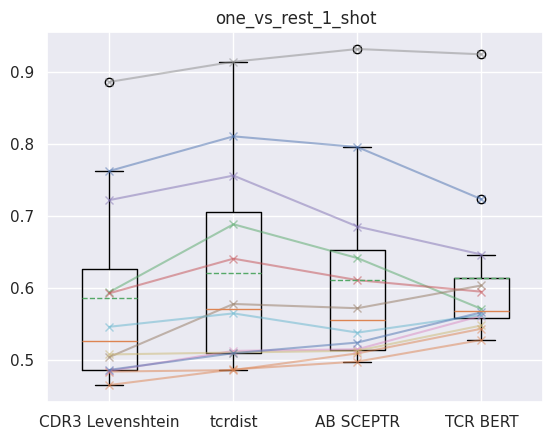

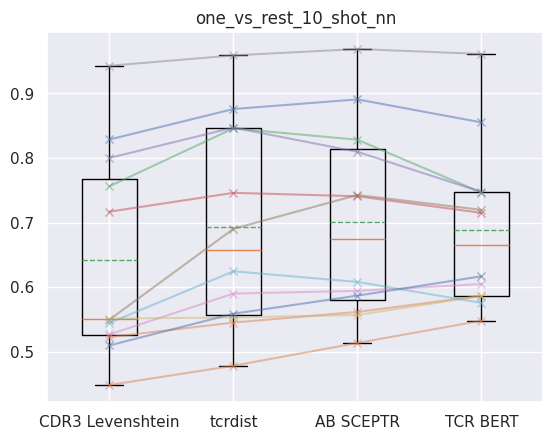

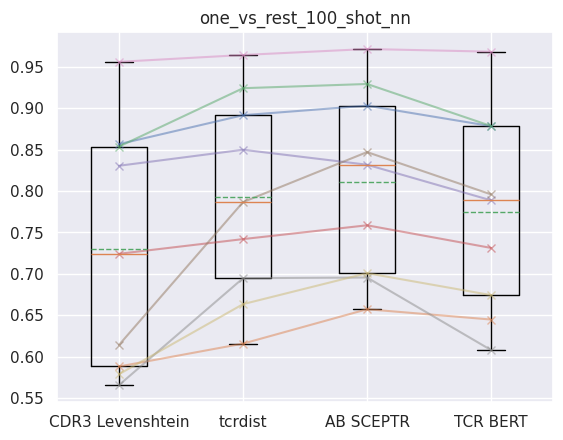

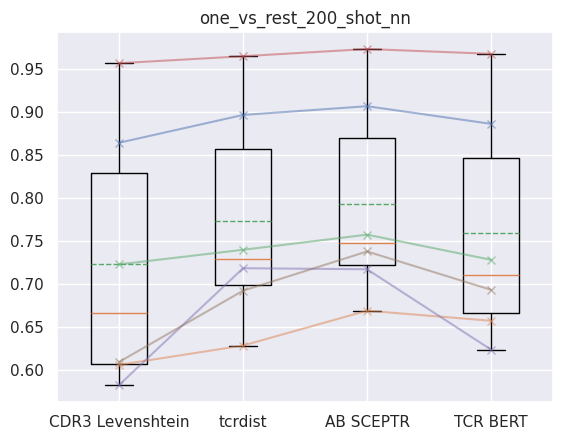

In [16]:
figs = {
    task_name: plot_auc_distributions(MODEL_NAMES, task_name) for task_name in TASKS
}